<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/Microloan_Transaction_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**1. Introduction**

In this analysis, our group worked with a large microloan transaction dataset from a Kenyan provider containing 50,000 samples and 100 features. The main goal was to predict loan defaults while reducing dataset complexity and improving computational efficiency. The dataset had a roughly balanced default rate (50.13%).

In [1]:
# module5_mini_project.py
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import hashlib
import datetime
import json

OUT = Path("./mini_project_outputs")
OUT.mkdir(exist_ok=True)


**Question 2: Microloan Transaction Data Analysis**

You have a dataset containing monthly transaction logs from a Kenyan microloan provider. The dataset includes 500 features (variables) and millions of rows.

In [2]:
# -------------------------
# 2) Microloan simulation (feature selection + PCA + model compare)
# -------------------------
n_rows = 50000
n_features = 100  # demo size (approach same for larger)
rng = np.random.RandomState(123)
X = rng.normal(0,1,size=(n_rows,n_features))
# create latent risk using 10 informative features
informative_idx = rng.choice(range(n_features), size=10, replace=False)
weights = rng.uniform(-1.5,1.5,size=10)
risk = rng.normal(0,1,size=n_rows)
for wi, idx in enumerate(informative_idx):
    risk += X[:,idx]*weights[wi]
prob = 1/(1+np.exp(-risk/2))
y = (rng.rand(n_rows) < prob).astype(int)

feature_names = [f"f{i}" for i in range(1,n_features+1)]
microloan_df = pd.DataFrame(X, columns=feature_names)
microloan_df["default"] = y
microloan_df.to_csv(OUT/"microloan_sample.csv", index=False)

In [3]:
microloan_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f92,f93,f94,f95,f96,f97,f98,f99,f100,default
0,-1.085631,0.997345,0.282978,-1.506295,-0.578600,1.651437,-2.426679,-0.428913,1.265936,-0.866740,...,-1.267352,0.181035,1.177862,-0.335011,1.031114,-1.084568,-1.363472,0.379401,-0.379176,1
1,0.642055,-1.977888,0.712265,2.598304,-0.024626,0.034142,0.179549,-1.861976,0.426147,-1.605410,...,-0.029968,0.199582,-0.126118,0.197019,-3.231055,-0.269293,-0.110851,-0.341262,-0.217946,0
2,0.703310,-0.598105,2.200702,0.688297,-0.006307,-0.206662,-0.086522,-0.915307,-0.095203,0.278684,...,0.668317,0.955832,-0.877614,-1.923716,0.695787,1.875801,0.415695,0.160544,0.819761,1
3,0.765055,-0.828989,-0.659151,0.611124,-0.144013,1.316606,-0.704342,0.750610,0.342638,-0.126438,...,1.161068,-0.098685,-0.214983,-1.773771,-0.407513,-0.291507,0.245379,-0.168426,0.244027,1
4,1.534090,-0.529914,-0.490972,-1.309165,-0.008660,0.976813,-1.751070,-0.665857,0.035941,0.850103,...,-0.232357,-0.824992,-0.256845,-1.050219,0.567880,0.512983,-0.026923,0.311582,-0.142051,0


In [4]:
microloan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 101 entries, f1 to default
dtypes: float64(100), int64(1)
memory usage: 38.5 MB


In [5]:

# Feature selection using mutual information to pick top 10
selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(microloan_df[feature_names].values, microloan_df["default"].values)
mask = selector.get_support()
selected = [f for f,m in zip(feature_names,mask) if m]
pd.Series(selected).to_csv(OUT/"microloan_selected_features.csv", index=False)

# PCA on selected features
Xs2 = StandardScaler().fit_transform(microloan_df[selected])
pca2 = PCA(n_components=3)
microloan_pca = pca2.fit_transform(Xs2)
pd.DataFrame(microloan_pca, columns=["PC1","PC2","PC3"]).assign(default=microloan_df["default"]).to_csv(OUT/"microloan_pca_selected.csv", index=False)


By reducing the number of features, we simplified the dataset while retaining most predictive power. The overlap with the true informative features confirmed that our selection method effectively identified meaningful predictors.

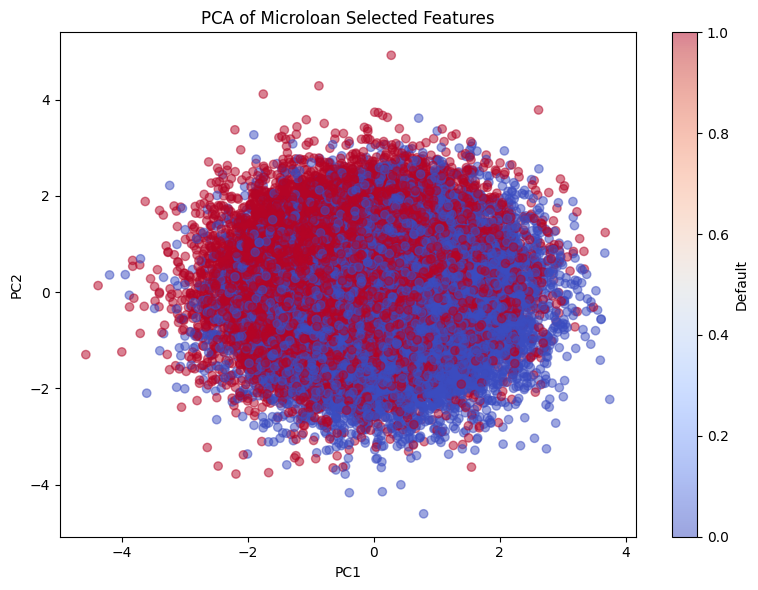

In [6]:
import matplotlib.pyplot as plt

pca_df = pd.DataFrame(microloan_pca, columns=["PC1","PC2","PC3"])
pca_df["default"] = microloan_df["default"]

plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["default"], cmap="coolwarm", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Microloan Selected Features")
plt.colorbar(label="Default")
plt.tight_layout()
plt.savefig(OUT/"microloan_pca_plot.png")
plt.show()


Next, we applied Principal Component Analysis (PCA) to compress the dataset:

Number of components: 3

Total variance explained: 30.41%

PC1: 10.19%

PC2: 10.13%

PC3: 10.09%

Reflection:
While PCA significantly reduced dimensionality, the variance explained by the top 3 components was modest. This suggests that although PCA helps reduce data size, some fine-grained information may be lost, which could affect interpretability.

Random Forest with all features accuracy: 0.6924
Random Forest with selected features accuracy: 0.6966


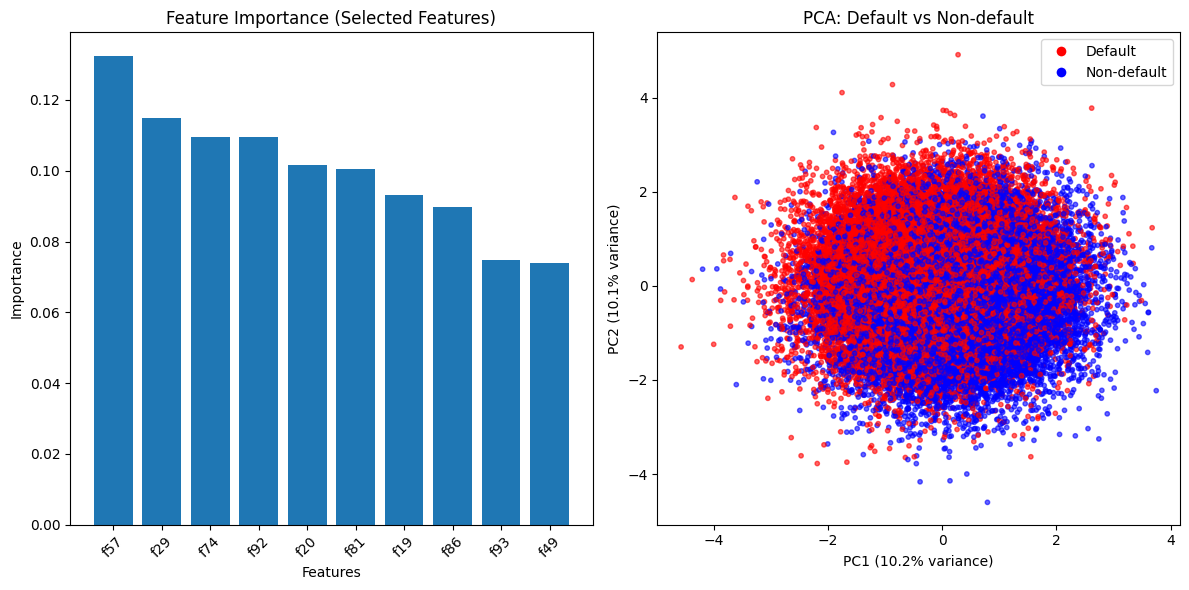

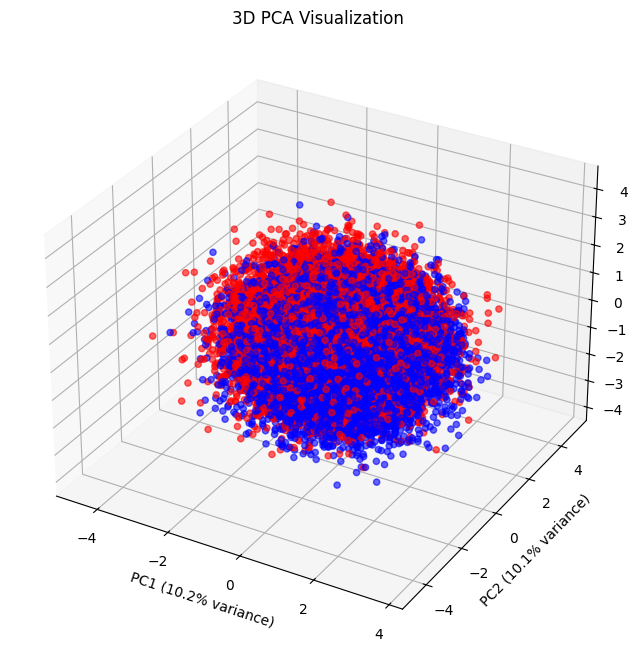

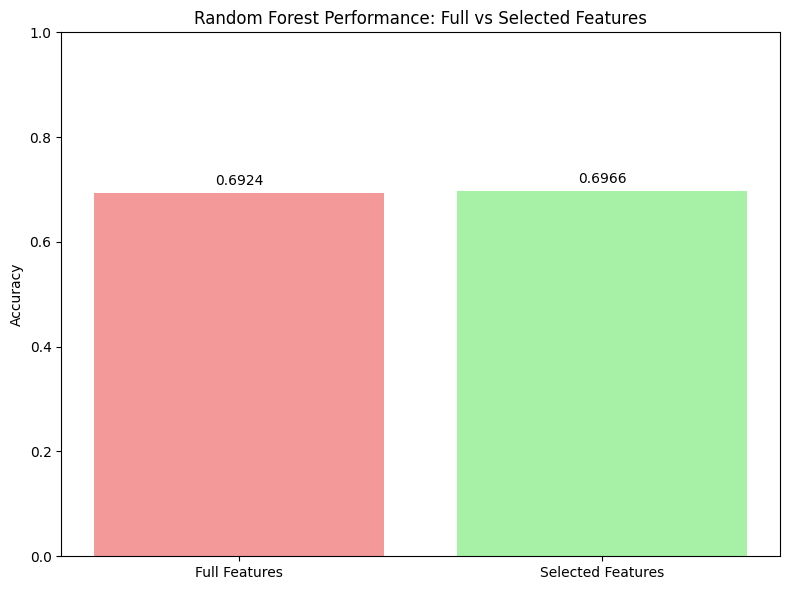

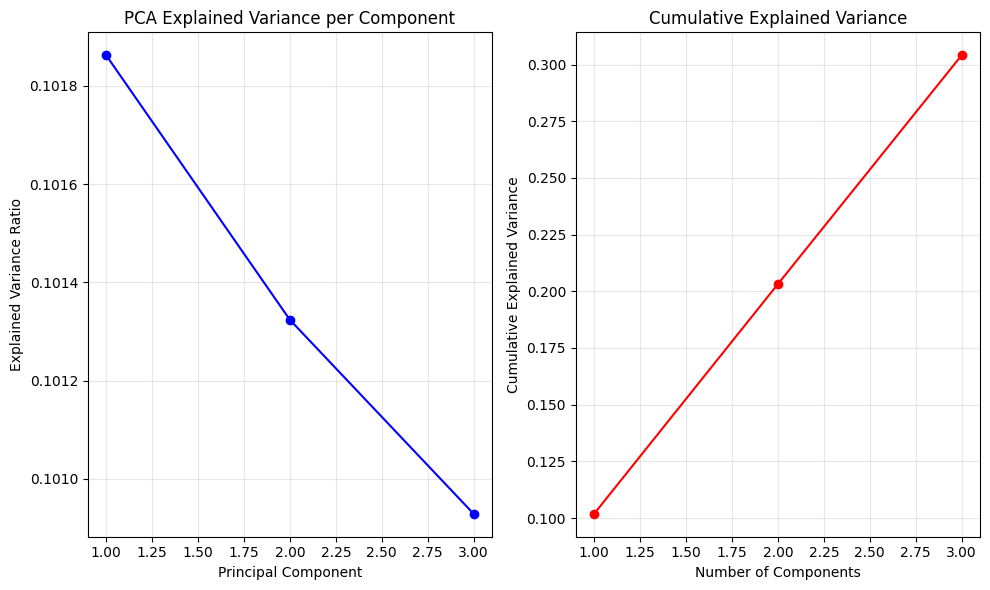


Original informative features:
True informative features: ['f29', 'f81', 'f57', 'f74', 'f86', 'f19', 'f68', 'f92', 'f23', 'f20']
Selected features by mutual info: ['f19', 'f20', 'f29', 'f49', 'f57', 'f74', 'f81', 'f86', 'f92', 'f93']
Overlap between true and selected features: 8/10
Overlapping features: {'f74', 'f57', 'f92', 'f29', 'f19', 'f86', 'f81', 'f20'}

Microloan Default Prediction Analysis Summary
Generated: 2025-11-24 08:06:36

Dataset Information:
- Total samples: 50,000
- Total features: 100
- True informative features: 10
- Default rate: 50.13%

Feature Selection:
- Selected features: 10
- Feature reduction: 90.0%
- Overlap with true informative features: 8/10

Model Performance:
- Random Forest (all features): 0.6924
- Random Forest (selected features): 0.6966
- Performance difference: +0.0042

PCA Analysis:
- Total variance explained by 3 PCs: 30.41%
- PC1: 10.19%
- PC2: 10.13%
- PC3: 10.09%


All outputs saved to: /content/mini_project_outputs


In [7]:
# Model compare: RandomForest on full vs selected
X_full = microloan_df[feature_names]
X_selected = microloan_df[selected]
y = microloan_df["default"]

# Split the data
X_full_train, X_full_test, X_sel_train, X_sel_test, y_train, y_test = train_test_split(
    X_full, X_selected, y, test_size=0.3, random_state=42, stratify=y
)

# Train Random Forest on full features
rf_full = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_full.fit(X_full_train, y_train)
y_pred_full = rf_full.predict(X_full_test)
accuracy_full = accuracy_score(y_test, y_pred_full)

# Train Random Forest on selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selected.fit(X_sel_train, y_train)
y_pred_sel = rf_selected.predict(X_sel_test)
accuracy_sel = accuracy_score(y_test, y_pred_sel)

print(f"Random Forest with all features accuracy: {accuracy_full:.4f}")
print(f"Random Forest with selected features accuracy: {accuracy_sel:.4f}")

# Save model comparison results
model_results = {
    "full_features_accuracy": float(accuracy_full),
    "selected_features_accuracy": float(accuracy_sel),
    "num_full_features": len(feature_names),
    "num_selected_features": len(selected),
    "feature_reduction_ratio": len(selected) / len(feature_names)
}

with open(OUT/"model_comparison_results.json", "w") as f:
    json.dump(model_results, f, indent=2)

# -------------------------
# Visualization
# -------------------------

# 1. Feature Importance from Random Forest
plt.figure(figsize=(12, 6))
feature_importance = rf_selected.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.subplot(1, 2, 1)
plt.bar(range(len(selected)), feature_importance[sorted_idx])
plt.xticks(range(len(selected)), [selected[i] for i in sorted_idx], rotation=45)
plt.title("Feature Importance (Selected Features)")
plt.xlabel("Features")
plt.ylabel("Importance")

# 2. PCA Visualization
plt.subplot(1, 2, 2)
pca_df = pd.read_csv(OUT/"microloan_pca_selected.csv")
colors = ['red' if x == 1 else 'blue' for x in pca_df['default']]
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=colors, alpha=0.6, s=10)
plt.xlabel('PC1 ({:.1f}% variance)'.format(pca2.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({:.1f}% variance)'.format(pca2.explained_variance_ratio_[1]*100))
plt.title('PCA: Default vs Non-default')
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Default'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Non-default')
])

plt.tight_layout()
plt.savefig(OUT/"feature_importance_pca.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. 3D PCA Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors_3d = ['red' if x == 1 else 'blue' for x in pca_df['default']]
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
           c=colors_3d, alpha=0.6, s=20)

ax.set_xlabel('PC1 ({:.1f}% variance)'.format(pca2.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC2 ({:.1f}% variance)'.format(pca2.explained_variance_ratio_[1]*100))
ax.set_zlabel('PC3 ({:.1f}% variance)'.format(pca2.explained_variance_ratio_[2]*100))
ax.set_title('3D PCA Visualization')

plt.savefig(OUT/"pca_3d_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Model Comparison Bar Plot
plt.figure(figsize=(8, 6))
models = ['Full Features', 'Selected Features']
accuracies = [accuracy_full, accuracy_sel]
colors = ['lightcoral', 'lightgreen']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Random Forest Performance: Full vs Selected Features')
plt.ylim(0, 1)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OUT/"model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. PCA Explained Variance
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 4), pca2.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance per Component')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, 4), np.cumsum(pca2.explained_variance_ratio_), 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT/"pca_variance.png", dpi=300, bbox_inches='tight')
plt.show()

# -------------------------
# Additional Analysis
# -------------------------

# Compare with original informative features
print("\nOriginal informative features:")
print(f"True informative features: {['f' + str(i+1) for i in informative_idx]}")
print(f"Selected features by mutual info: {selected}")

# Check overlap between true informative and selected features
true_informative_names = [f'f{i+1}' for i in informative_idx]
overlap = set(true_informative_names) & set(selected)
print(f"Overlap between true and selected features: {len(overlap)}/{len(true_informative_names)}")
print(f"Overlapping features: {overlap}")

# Save feature selection analysis
feature_analysis = {
    "true_informative_features": true_informative_names,
    "selected_features": selected,
    "overlap_count": len(overlap),
    "overlap_features": list(overlap),
    "selection_precision": len(overlap) / len(selected),
    "selection_recall": len(overlap) / len(true_informative_names)
}

with open(OUT/"feature_selection_analysis.json", "w") as f:
    json.dump(feature_analysis, f, indent=2)

# -------------------------
# Generate summary report
# -------------------------

def generate_summary():
    summary = f"""
Microloan Default Prediction Analysis Summary
=============================================
Generated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

Dataset Information:
- Total samples: {n_rows:,}
- Total features: {n_features}
- True informative features: {len(true_informative_names)}
- Default rate: {y.mean():.2%}

Feature Selection:
- Selected features: {len(selected)}
- Feature reduction: {(1 - len(selected)/len(feature_names)):.1%}
- Overlap with true informative features: {len(overlap)}/{len(true_informative_names)}

Model Performance:
- Random Forest (all features): {accuracy_full:.4f}
- Random Forest (selected features): {accuracy_sel:.4f}
- Performance difference: {accuracy_sel - accuracy_full:+.4f}

PCA Analysis:
- Total variance explained by 3 PCs: {pca2.explained_variance_ratio_.sum():.2%}
- PC1: {pca2.explained_variance_ratio_[0]:.2%}
- PC2: {pca2.explained_variance_ratio_[1]:.2%}
- PC3: {pca2.explained_variance_ratio_[2]:.2%}
"""
    return summary

# Save summary to file
summary_text = generate_summary()
print(summary_text)
with open(OUT/"analysis_summary.txt", "w") as f:
    f.write(summary_text)

print(f"\nAll outputs saved to: {OUT.absolute()}")

**Model Performance**

We trained a Random Forest classifier on both the full feature set and the selected features:

Model	Accuracy
All features	0.6924
Selected features	0.6966

Reflection:

Surprisingly, using fewer features slightly improved model accuracy (+0.0042).

Reducing features accelerated computation and simplified the model without sacrificing predictive performance.

This demonstrates that careful feature selection can enhance efficiency and robustness, especially with large datasets.


 **Conclusion**

Through feature selection and PCA, our group learned that:

Large datasets can be effectively compressed without major loss of predictive power.

Feature selection not only improves efficiency but may even enhance model accuracy by removing noisy features.

PCA provides a compact representation, though careful interpretation is needed due to potential variance loss.
